In [12]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [13]:
df = pd.read_csv('PAS+crime+extra_final.csv')

In [14]:
df.shape[0]

75912

In [15]:
df.dropna(subset=['NQ135BD'], inplace=True)
df = df[df['NQ135BD'] < 95]
print(df.shape[0])

75664


In [16]:
columns_to_drop = df.filter(regex='^WT_').columns
df = df.drop(columns=columns_to_drop)
print(df.shape[0])
print(df.shape[1])

75664
599


In [17]:
# Define features and target
X = df.drop(columns='NQ135BD')
y = df['NQ135BD']

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression task
    'random_state': 42
}

# Convert training data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Convert testing data into DMatrix format for XGBoost
dtest = xgb.DMatrix(X_test, label=y_test)

# Number of boosting rounds
num_boost_round = 100

# Train the model and print the progress of boosting rounds
evals_result = {}
model = xgb.train(params, dtrain, num_boost_round=num_boost_round,
                  evals=[(dtrain, 'train'), (dtest, 'test')],
                  early_stopping_rounds=10, verbose_eval=10, evals_result=evals_result)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Calculate and print RMSE (Root Mean Squared Error) on the test set
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE on test set:", rmse)


[0]	train-rmse:0.78575	test-rmse:0.76996
[10]	train-rmse:0.60208	test-rmse:0.61944
[20]	train-rmse:0.57791	test-rmse:0.61341
[30]	train-rmse:0.56044	test-rmse:0.61243
[34]	train-rmse:0.55549	test-rmse:0.61231
RMSE on test set: 0.612433166208974


In [19]:
# Compute baseline RMSE
baseline_rmse = rmse

# Initialize an empty array to store permutation importances
perm_importances = np.zeros(X_test.shape[1])

# Set random seed for reproducibility
np.random.seed(42)

# Number of permutations
n_permutations = 10

# Iterate over each feature
for i in tqdm(range(X_test.shape[1]), desc="Calculating Permutation Importance"):
    perm_importances_temp = []
    for _ in range(n_permutations):
        # Make a copy of the test data
        X_test_permuted = X_test.copy()
        # Permute the values of the current feature
        X_test_permuted.iloc[:, i] = np.random.permutation(X_test_permuted.iloc[:, i])
        # Make predictions on the permuted data
        y_pred_permuted = model.predict(xgb.DMatrix(X_test_permuted))
        # Compute RMSE on the permuted data
        permuted_rmse = mean_squared_error(y_test, y_pred_permuted, squared=False)
        # Compute permutation importance for the current feature
        perm_importance = baseline_rmse - permuted_rmse
        # Store the permutation importance
        perm_importances_temp.append(perm_importance)
    # Average the permutation importance over multiple permutations
    perm_importances[i] = np.mean(perm_importances_temp)

# Sort the permutation importances
sorted_idx = np.argsort(perm_importances)[::-1]

# Print the top 20 features by permutation importance
print("Top 20 Feature Importance:")
for i in sorted_idx[:20]:
    print(f"{X.columns[i]}: {perm_importances[i]:.4f}")


Calculating Permutation Importance: 100%|█████| 598/598 [30:41<00:00,  3.08s/it]

Top 20 Feature Importance:
selfemployed_number: 0.0002
Q54C: 0.0002
Q39BD: 0.0001
Black: 0.0001
Q10D: 0.0001
Vehicle crime: 0.0001
NQ135BB: 0.0001
ZQ10E: 0.0001
NQ2G: 0.0001
SQ79DF: 0.0001
NQ135BN: 0.0001
Public order: 0.0001
ReQ139: 0.0001
Q10H: 0.0001
XQ106B: 0.0001
TQ132: 0.0001
XQ128A2A: 0.0001
SQ79EH: 0.0001
NQCV27: 0.0001
Robbery: 0.0001


In [20]:
# Select the top 20 most important features
top_features = X.columns[sorted_idx[:20]]

# Create a new DataFrame with only the top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Retrain the model using only the top features
dtrain_top = xgb.DMatrix(X_train_top, label=y_train)
dtest_top = xgb.DMatrix(X_test_top, label=y_test)

model_top = xgb.train(params, dtrain_top, num_boost_round=num_boost_round,
                      evals=[(dtrain_top, 'train'), (dtest_top, 'test')],
                      early_stopping_rounds=10, verbose_eval=10, evals_result=evals_result)

# Make predictions on the test set with the top features
y_pred_top = model_top.predict(dtest_top)

# Calculate and print RMSE on the test set with the top features
rmse_top = mean_squared_error(y_test, y_pred_top, squared=False)
print("RMSE on test set with top features:", rmse_top)

[0]	train-rmse:0.87056	test-rmse:0.85220
[10]	train-rmse:0.83875	test-rmse:0.83626
[20]	train-rmse:0.82709	test-rmse:0.83627
[21]	train-rmse:0.82567	test-rmse:0.83634
RMSE on test set with top features: 0.836292384020747


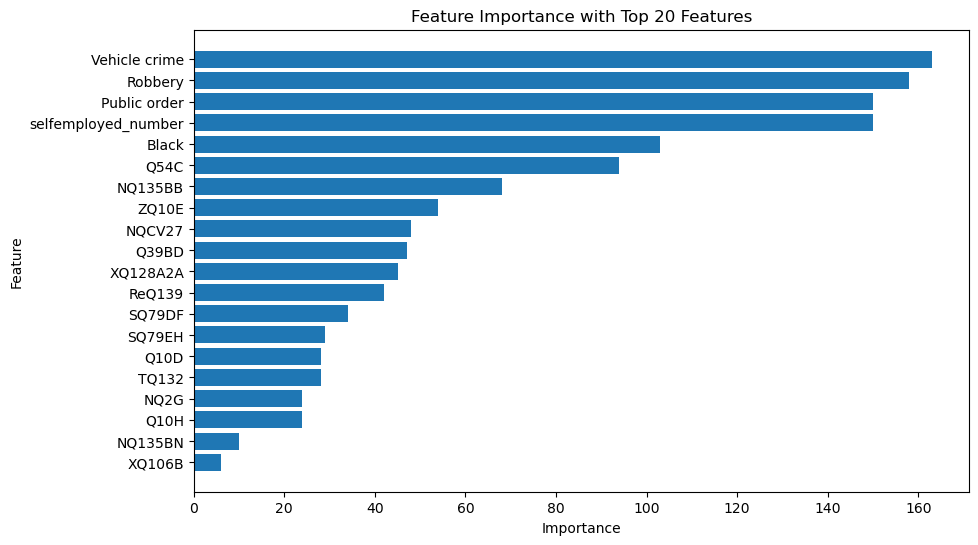

                Feature  Importance
5         Vehicle crime       163.0
19              Robbery       158.0
11         Public order       150.0
0   selfemployed_number       150.0
3                 Black       103.0
1                  Q54C        94.0
6               NQ135BB        68.0
7                 ZQ10E        54.0
18               NQCV27        48.0
2                 Q39BD        47.0
16             XQ128A2A        45.0
12               ReQ139        42.0
9                SQ79DF        34.0
17               SQ79EH        29.0
4                  Q10D        28.0
15                TQ132        28.0
8                  NQ2G        24.0
13                 Q10H        24.0
10              NQ135BN        10.0
14               XQ106B         6.0


In [21]:
# Get feature importance scores
feature_importance = model_top.get_score(importance_type='weight')

# Convert to DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),
    'Importance': list(feature_importance.values())
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance with Top 20 Features')
plt.gca().invert_yaxis()
plt.show()

# Print feature importance
print(importance_df)